# Solution au problème du nombre de GPUs

Le problème auquel s'attaque Infrascale peut-être traité comme un problème d'optimisation sous contrainte non convexe. Compte tenu de $S$ la taille d'un cluster de GPUs et $N$ le nombre de clusters parallèles, on cherche à minimiser le nombre total de GPUs $S \times N$. Il y a trois contraintes :

- Une **contrainte de mémoire** : il doit y avoir assez de GPUs dans un cluster ($S$) pour accueillir les poids du modèle et faire de l'inférence.
- Une **contrainte de vitesse** : le débit en tokens/s (dépend différement de $S$ et $N$) doit être supérieur ou égal à un seuil fixé par l'utilisateur.
- Une **contrainte de saturation** : le nombre moyen (on peut aussi raisonner au 95e percentile) de requêtes traitées par un cluster doit être inférieur ou égal à la batch size maximale de traitable par ce dernier pour éviter l'accumulation de requêtes en file d'attente.

Le but de ce notebook est de développer une méthode de résolution algorithmique de ce problème d'optimisation avant implémentation dans Infrascale. La première piste est celle de la descente de gradient sur une fonction objectif (le nombre total de GPUs) pénalisée par les contraintes. Nous pouvons effectivement calculer un gradient pour chaque contrainte et pour la fonction objectif.

## Formules

### Contraintes

Les contraintes de mémoire et de vitesse sont calculées en fonction d'autres variables (batch size, modèle, gpu, heuristiques...) dont on peu faire abstraction en les ramenenant à une constante dans la mesure où nous ne nous intéressons qu'à l'impact du nombre de GPUs. On a pour les formules de nos contraintes :

- $c_{mem}(S,N)=\frac{K_{mem}}{1+E(S-1)}-1$

- $c_{speed}(S,N)= 1 - \frac{N(1+E(S-1)) \times K_{speed}}{targetspeed}$

- $c_{saturation}(S,N)=\frac{users}{batchsize \times N}-1$

où $K_{mem}$ et $K_{speed}$ sont les constantes mentionnées plus haut et $E$ est un facteur d'efficacité de la parallélisation de plusieurs GPUs au sein d'un cluster, on a généralement $E=0,85$ : chaque GPU supplémentaire dans un cluster contribue à hauteur de 85% de son "potentiel".

### Gradients

On déduit immédiatement les gradients des contraintes :

- $\nabla c_{mem}(S,N)=\begin{pmatrix} -\frac{K_{mem}}{ES^2} , 0 \end{pmatrix}$

- $\nabla c_{speed}(S,N)=-\frac{K_{speed}}{targetspeed}\begin{pmatrix} NE, 1+E(S-1) \end{pmatrix}$

- $\nabla c_{saturation}(S,N)=\begin{pmatrix} 0 , -\frac{users}{batchsize \times N^2} \end{pmatrix}$

On ajoute le gradient de la fonction objectif :

- $\nabla f(S,N)=\begin{pmatrix} N , S \end{pmatrix}$

### Problèmes d'optimisation

Chaque étape de notre algorithme nous amène à résoudre un problème du format suivant :

$\min_{S,N}  f_p(S,N) := f(S,N)+p(g_{mem}(S,N) + g_{speed}(S,N) + g_{saturation}(S,N))$

où $p$ est le coefficient de pénalité et $g_i(S,N)=\max(c_i(S,N), 0)^2$

On résoudra ce problème avec une descente de gradient.

## Implémentation

### Imports

In [9]:
from math import log10
import numpy as np
import matplotlib.pyplot as plt

### Calcul des constantes

In [10]:
def calculate_kv_cache_memory(**kwargs):
    model_layers = kwargs['model_layers']
    model_dim = kwargs['model_dim']
    batch_size = kwargs['batch_size']
    tokens_per_request = kwargs['tokens_per_request']
    bytes_per_param = kwargs['bytes_per_param']

    bytes_to_gb = 2**30

    kv_cache_bytes = (
        2 * model_layers * model_dim * batch_size *
        tokens_per_request * bytes_per_param
    )
    return kv_cache_bytes / bytes_to_gb

def calculate_memory_constant(**kwargs):
    model_b_params = kwargs['model_b_params']
    model_layers = kwargs['model_layers']
    model_dim = kwargs['model_dim']
    gpu_vram_gb = kwargs['gpu_vram_gb']
    batch_size = kwargs['batch_size']
    tokens_per_request = kwargs['tokens_per_request']
    bytes_per_param = kwargs['bytes_per_param']
    memory_overhead_percent = kwargs['memory_overhead_percent']

    bytes_to_gb = 2**30

    model_mem_gb = model_b_params * bytes_per_param
    activations_mem_gb = (batch_size * tokens_per_request * model_dim * bytes_per_param) / bytes_to_gb
    kv_cache_mem_gb = calculate_kv_cache_memory(**kwargs)

    total_mem_gb = (model_mem_gb + activations_mem_gb + kv_cache_mem_gb) * (1 + memory_overhead_percent / 100)

    return total_mem_gb / gpu_vram_gb

def calculate_speed_constant(**kwargs):
    users = kwargs['users']
    batch_size = kwargs['batch_size']
    prompt_size = kwargs['prompt_size']
    model_b_params = kwargs['model_b_params']
    model_dim = kwargs['model_dim']
    gpu_flops = kwargs['gpu_flops']
    gpu_bandwidth = kwargs['gpu_bandwidth']
    
    gpu_flops = gpu_flops * 10**12 * 0.55
    gpu_bandwidth = gpu_bandwidth * 10**12

    flops_decode_one_token = batch_size * model_b_params * 2 * 1e9
    mm_params = model_b_params*10**9
    mm_kv_read = 2 * batch_size * prompt_size * model_dim
    mm_kv_write = 2 * batch_size * model_dim
    mm_decode_one_token = 2 * (mm_params + mm_kv_read + mm_kv_write)
    tpot = max(flops_decode_one_token / gpu_flops, mm_decode_one_token / gpu_bandwidth)

    k = 24/model_b_params
    recalibration_factor = k**(-1/(k+1))
    calibrated_tpot = tpot / recalibration_factor * log10(min(users, batch_size)+30)

    throughput_one_gpu = 1 / calibrated_tpot

    return throughput_one_gpu

### Calcul des contraintes

In [11]:
def calculate_mem_constraint(S, N, **kwargs):
  E = kwargs['efficiency_factor']
  K = calculate_memory_constant(**kwargs)
  constraint = K / (1 + E * (S - 1)) - 1

  return constraint

def calculate_speed_constraint(S, N, **kwargs):
  E = kwargs['efficiency_factor']
  target_speed = kwargs['target_speed']
  K = calculate_speed_constant(**kwargs)
  # constraint = 1 - N * (1 + E * (S - 1)) * K / target_speed
  constraint = 1 - N * (1 + E * (S - 1)) * K / target_speed
  
  return constraint

def calculate_saturation_constraint(S, N, **kwargs):
  users = kwargs['users']
  batch_size = kwargs['batch_size']
  constraint = users / (batch_size * N) - 1

  return constraint

### Calcul des gradients

In [12]:
def mem_gradient(S, N, **kwargs):
  E = kwargs['efficiency_factor']
  K = calculate_memory_constant(**kwargs)
  d_S = - K / (E * S**2)
  d_N = 0

  return d_S, d_N

def speed_gradient(S, N, **kwargs):
  E = kwargs['efficiency_factor']
  target_speed = kwargs['target_speed']
  K = calculate_speed_constant(**kwargs)
  d_S = - N * E * K / target_speed
  d_N = - (1 + E * (S - 1)) * K / target_speed

  return d_S, d_N

def saturation_gradient(S, N, **kwargs):
  users = kwargs['users']
  batch_size = kwargs['batch_size']
  d_S = 0
  d_N = - users / (batch_size * N**2)

  return d_S, d_N

def f_gradient(S, N):
  d_S = N
  d_N = S

  return d_S, d_N

In [13]:
def penalty_function(constraint_value):
    """Calculate g_i(S,N) = max(c_i(S,N), 0)^2"""
    return max(constraint_value, 0)**2

def penalty_gradient(constraint_value, constraint_gradient):
    """Calculate gradient of g_i(S,N) = max(c_i(S,N), 0)^2"""
    if constraint_value > 0:
        return 2 * constraint_value * np.array(constraint_gradient)
    else:
        return np.array([0.0, 0.0])

def penalized_objective(S, N, penalty_coeff, **kwargs):
    """Calculate the penalized objective function f_p(S,N)"""
    # Objective function: total GPUs
    f_val = S * N
    
    # Calculate constraints
    c_mem = calculate_mem_constraint(S, N, **kwargs)
    c_speed = calculate_speed_constraint(S, N, **kwargs)
    c_sat = calculate_saturation_constraint(S, N, **kwargs)
    
    # Calculate penalty terms
    g_mem = penalty_function(c_mem)
    g_speed = penalty_function(c_speed)
    g_sat = penalty_function(c_sat)
    
    # Penalized objective
    f_p = f_val + penalty_coeff * (g_mem + g_speed + g_sat)
    
    return f_p, (c_mem, c_speed, c_sat)

def penalized_gradient(S, N, penalty_coeff, **kwargs):
    """Calculate gradient of the penalized objective function"""
    # Objective function gradient
    df_dS, df_dN = f_gradient(S, N)
    grad_f = np.array([df_dS, df_dN])
    
    # Calculate constraints and their gradients
    c_mem = calculate_mem_constraint(S, N, **kwargs)
    c_speed = calculate_speed_constraint(S, N, **kwargs)
    c_sat = calculate_saturation_constraint(S, N, **kwargs)
    
    grad_c_mem = np.array(mem_gradient(S, N, **kwargs))
    grad_c_speed = np.array(speed_gradient(S, N, **kwargs))
    grad_c_sat = np.array(saturation_gradient(S, N, **kwargs))
    
    # Calculate penalty gradients
    grad_g_mem = penalty_gradient(c_mem, grad_c_mem)
    grad_g_speed = penalty_gradient(c_speed, grad_c_speed)
    grad_g_sat = penalty_gradient(c_sat, grad_c_sat)
    
    # Total gradient
    grad_total = grad_f + penalty_coeff * (grad_g_mem + grad_g_speed + grad_g_sat)
    
    return grad_total

def gradient_descent_step(S, N, learning_rate, penalty_coeff, **kwargs):
    """Perform one step of gradient descent"""
    grad = penalized_gradient(S, N, penalty_coeff, **kwargs)
    
    # Update variables
    S_new = S - learning_rate * grad[0]
    N_new = N - learning_rate * grad[1]
    
    # Ensure S and N remain positive (project onto feasible domain)
    S_new = max(1.0, S_new)
    N_new = max(1.0, N_new)
    
    return S_new, N_new

def detect_oscillation(history, window_size=100, oscillation_threshold=0.1):
    """
    Detect if variables are oscillating (sign of numerical instability)
    
    Parameters:
    - history: List of variable values
    - window_size: Number of recent values to check
    - oscillation_threshold: Relative change threshold for detecting oscillation
    
    Returns:
    - is_oscillating: Boolean indicating if oscillation is detected
    """
    if len(history) < window_size:
        return False
    
    recent_values = history[-window_size:]
    mean_val = np.mean(recent_values)

    jumps = 0
    
    for i in range(1, len(recent_values)):
        if abs(recent_values[i] - recent_values[i-1]) > oscillation_threshold:
            jumps += 1

    return jumps > window_size * 0.25

def penalty_method_solver(penalty_init=1.0, penalty_multiplier=10.0, 
                         learning_rate=0.01, max_iterations=1000, 
                         tolerance=1e-6, max_penalty_iterations=10,
                         oscillation_threshold=0.01,
                         **kwargs):
    """
    Solve the constrained optimization problem using penalty method with gradient descent
    
    Parameters:
    - S_init, N_init: Initial values for cluster size and number of clusters
    - penalty_init: Initial penalty coefficient
    - penalty_multiplier: Factor to increase penalty coefficient
    - learning_rate: Step size for gradient descent
    - max_iterations: Maximum iterations per penalty iteration
    - tolerance: Convergence tolerance
    - max_penalty_iterations: Maximum number of penalty iterations
    - **kwargs: Additional parameters for memory and speed calculations
    """    
    
    S, N = 1, kwargs['users'] / kwargs['batch_size']
    penalty_coeff = penalty_init
    
    # Store last stable state
    last_stable_S, last_stable_N = S, N
    last_stable_results = None
    
    results = {
        'S_history': [],
        'N_history': [],
        'objective_history': [],
        'constraint_violations': [],
        'penalty_coefficients': [],
        'stability_status': [],
        'stopped_due_to_instability': False,
        'instability_reason': None
    }
    
    print(f"Starting penalty method optimization...")
    print(f"Initial: S={S:.2f}, N={N:.2f}, Total GPUs={S*N:.2f}")

    for penalty_iter in range(max_penalty_iterations):
        print(f"\n--- Penalty iteration {penalty_iter + 1}, penalty coeff = {penalty_coeff:.2e} ---")
        
        prev_S, prev_N = S, N
        
        # Gradient descent for current penalty coefficient
        for iter in range(max_iterations):
            try:
                # Calculate current objective and constraints
                f_p, constraints = penalized_objective(S, N, penalty_coeff, **kwargs)
                
                # Calculate gradient for stability check
                grad = penalized_gradient(S, N, penalty_coeff, **kwargs)
                
                # Check for oscillation
                if len(results['S_history']) > 0:
                    S_oscillating = detect_oscillation(results['S_history'], window_size=max_iterations, oscillation_threshold=oscillation_threshold)
                    N_oscillating = detect_oscillation(results['N_history'], window_size=max_iterations, oscillation_threshold=oscillation_threshold)
                    
                    if S_oscillating or N_oscillating:
                        print(f"  OSCILLATION DETECTED in {'S' if S_oscillating else 'N'}")
                        print(f"  This may indicate numerical instability")
                        print(f"  Stopping optimization and returning last stable result")
                        print(f"  Last stable: S={last_stable_S:.2f}, N={last_stable_N:.2f}, Total GPUs={last_stable_S*last_stable_N:.2f}")
                        
                        results['stopped_due_to_instability'] = True
                        results['instability_reason'] = f"Oscillation detected in {'S' if S_oscillating else 'N'}"
                        
                        if last_stable_results is not None:
                            return last_stable_S, last_stable_N, last_stable_results
                        else:
                            return S, N, results
                
                # Store results (current state is stable)
                results['S_history'].append(S)
                results['N_history'].append(N)
                results['objective_history'].append(S * N)  # Original objective
                results['constraint_violations'].append(constraints)
                results['penalty_coefficients'].append(penalty_coeff)
                results['stability_status'].append("stable")
                
                # Update last stable state
                last_stable_S, last_stable_N = S, N
                last_stable_results = {
                    'S_history': results['S_history'].copy(),
                    'N_history': results['N_history'].copy(),
                    'objective_history': results['objective_history'].copy(),
                    'constraint_violations': results['constraint_violations'].copy(),
                    'penalty_coefficients': results['penalty_coefficients'].copy(),
                    'stability_status': results['stability_status'].copy(),
                    'stopped_due_to_instability': False,
                    'instability_reason': None
                }
                
                # Perform gradient descent step
                S_new, N_new = gradient_descent_step(S, N, learning_rate, penalty_coeff, **kwargs)
                
                # Check convergence
                if abs(S_new - S) < tolerance and abs(N_new - N) < tolerance:
                    print(f"  Converged after {iter + 1} iterations")
                    break
                
                S, N = S_new, N_new
                
                if iter % 100 == 0:
                    print(f"  Iter {iter}: S={S:.2f}, N={N:.2f}, Total GPUs={S*N:.2f}, Constraints: {[f'{c:.3f}' for c in constraints]}")
                    
            except Exception as e:
                print(f"  EXCEPTION DURING OPTIMIZATION: {str(e)}")
                print(f"  This likely indicates numerical instability")
                print(f"  Stopping optimization and returning last stable result")
                print(f"  Last stable: S={last_stable_S:.2f}, N={last_stable_N:.2f}, Total GPUs={last_stable_S*last_stable_N:.2f}")
                
                results['stopped_due_to_instability'] = True
                results['instability_reason'] = f"Exception during optimization: {str(e)}"
                
                if last_stable_results is not None:
                    return last_stable_S, last_stable_N, last_stable_results
                else:
                    return S, N, results
        
        # Check constraint satisfaction
        max_violation = max(0, max(constraints))
        print(f"  Final: S={S:.2f}, N={N:.2f}, Total GPUs={S*N:.2f}")
        print(f"  Max constraint violation: {max_violation:.6f}")
        
        # If constraints are satisfied within tolerance, we're done
        if max_violation < tolerance:
            print(f"\nOptimization converged! Constraints satisfied.")
            break
        
        # Otherwise, increase penalty coefficient and continue
        penalty_coeff *= penalty_multiplier
        
        # Check if we're making progress
        if abs(S - prev_S) < tolerance and abs(N - prev_N) < tolerance:
            print(f"\nWarning: No progress made in penalty iteration {penalty_iter + 1}")
    
    return S, N, results

def plot_optimization_results(results):
    """Plot the optimization results"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    iterations = range(len(results['S_history']))
    
    # Plot S and N evolution
    axes[0, 0].plot(iterations, results['S_history'], label='S (cluster size)')
    axes[0, 0].plot(iterations, results['N_history'], label='N (num clusters)')
    
    # Add marker for instability if detected
    if results.get('stopped_due_to_instability', False):
        axes[0, 0].axvline(x=len(iterations)-1, color='red', linestyle='--', alpha=0.7, 
                          label=f'Instability: {results.get("instability_reason", "Unknown")}')
    
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Value')
    axes[0, 0].set_title('S and N Evolution')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot objective function
    axes[0, 1].plot(iterations, results['objective_history'])
    if results.get('stopped_due_to_instability', False):
        axes[0, 1].axvline(x=len(iterations)-1, color='red', linestyle='--', alpha=0.7, 
                          label='Stopped due to instability')
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('Total GPUs')
    axes[0, 1].set_title('Objective Function (Total GPUs)')
    axes[0, 1].grid(True)
    if results.get('stopped_due_to_instability', False):
        axes[0, 1].legend()
    
    # Plot constraint violations
    constraints_array = np.array(results['constraint_violations'])
    axes[1, 0].plot(iterations, constraints_array[:, 0], label='Memory constraint')
    axes[1, 0].plot(iterations, constraints_array[:, 1], label='Speed constraint')
    axes[1, 0].plot(iterations, constraints_array[:, 2], label='Saturation constraint')
    axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    if results.get('stopped_due_to_instability', False):
        axes[1, 0].axvline(x=len(iterations)-1, color='red', linestyle='--', alpha=0.7)
    axes[1, 0].set_xlabel('Iteration')
    axes[1, 0].set_ylabel('Constraint Value')
    axes[1, 0].set_title('Constraint Violations')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Plot penalty coefficients
    axes[1, 1].semilogy(iterations, results['penalty_coefficients'])
    if results.get('stopped_due_to_instability', False):
        axes[1, 1].axvline(x=len(iterations)-1, color='red', linestyle='--', alpha=0.7)
    axes[1, 1].set_xlabel('Iteration')
    axes[1, 1].set_ylabel('Penalty Coefficient')
    axes[1, 1].set_title('Penalty Coefficient Evolution')
    axes[1, 1].grid(True)
    
    # Add overall stability information
    if results.get('stopped_due_to_instability', False):
        fig.suptitle(f'Optimization Results (Stopped due to: {results.get("instability_reason", "Unknown")})', 
                    fontsize=14, color='red')
    else:
        fig.suptitle('Optimization Results (Completed Successfully)', fontsize=14, color='green')
    
    plt.tight_layout()
    plt.show()
    
    # Print stability summary
    print(f"\n=== STABILITY ANALYSIS ===")
    if results.get('stopped_due_to_instability', False):
        print(f"❌ Optimization stopped due to numerical instability")
        print(f"Reason: {results.get('instability_reason', 'Unknown')}")
        print(f"Total stable iterations: {len(results['S_history'])}")
    else:
        print(f"✅ Optimization completed successfully")
        print(f"Total iterations: {len(results['S_history'])}")
        stable_count = results.get('stability_status', []).count('stable')
        print(f"Stable iterations: {stable_count}/{len(results['S_history'])}")

# Example usage and test
def test_optimization():
    """Test the optimization with example parameters"""
    # Example parameters (you may need to adjust these based on your specific problem)
    params = {
        'users': 5000,
        'target_speed': 20,
        'batch_size': 256,
        'model_b_params': 24,  # Model size in billions of parameters
        'model_layers': 40,
        'model_dim': 5120,
        'bytes_per_param': 2,  # 2 bytes for half precision
        'tokens_per_request': 512,
        'memory_overhead_percent': 20,
        'prompt_size': 256,
        'efficiency_factor': 0.85,
        'gpu_vram_gb': 80,  # GPU VRAM in GB
        'gpu_flops': 1989,  # TFLOPS
        'gpu_bandwidth': 3350  # GB/s
    }
    
    print(f"Testing optimization with target speed: {params['target_speed']} tokens/s")
    print(f"Users: {params['users']}, Batch size: {params['batch_size']}")
    
    # Run optimization
    S_opt, N_opt, results = penalty_method_solver(
        penalty_init=1.0,
        penalty_multiplier=5,
        learning_rate=0.01,
        max_iterations=500,
        tolerance=1e-6,
        max_penalty_iterations=10,
        oscillation_threshold=2,
        **params
    )
    
    print(f"\n=== OPTIMIZATION RESULTS ===")
    print(f"Optimal cluster size (S): {S_opt:.2f}")
    print(f"Optimal number of clusters (N): {N_opt:.2f}")
    print(f"Total GPUs needed: {S_opt * N_opt:.2f}")
    
    # Verify constraints at optimum
    c_mem = calculate_mem_constraint(S_opt, N_opt, **params)
    c_speed = calculate_speed_constraint(S_opt, N_opt, **params)
    c_sat = calculate_saturation_constraint(S_opt, N_opt, **params)
    
    print(f"\nConstraint values at optimum:")
    print(f"Memory constraint: {c_mem:.6f} (should be ≤ 0)")
    print(f"Speed constraint: {c_speed:.6f} (should be ≤ 0)")
    print(f"Saturation constraint: {c_sat:.6f} (should be ≤ 0)")
    
    # Plot results
    plot_optimization_results(results)
    
    return S_opt, N_opt, results


Testing optimization with target speed: 20 tokens/s
Users: 5000, Batch size: 256
Starting penalty method optimization...
Initial: S=1.00, N=19.53, Total GPUs=19.53

--- Penalty iteration 1, penalty coeff = 1.00e+00 ---
  Iter 0: S=1.00, N=19.52, Total GPUs=19.52, Constraints: ['1.239', '-34.393', '0.000']
  Iter 100: S=1.00, N=18.52, Total GPUs=18.52, Constraints: ['1.239', '-32.587', '0.054']
  Iter 200: S=1.00, N=17.53, Total GPUs=17.53, Constraints: ['1.239', '-30.793', '0.113']
  Iter 300: S=1.00, N=16.55, Total GPUs=16.55, Constraints: ['1.239', '-29.016', '0.179']
  Iter 400: S=1.00, N=15.59, Total GPUs=15.59, Constraints: ['1.239', '-27.263', '0.252']
  Final: S=1.00, N=14.65, Total GPUs=14.65
  Max constraint violation: 1.238750

--- Penalty iteration 2, penalty coeff = 5.00e+00 ---
  Iter 0: S=1.18, N=14.64, Total GPUs=17.27, Constraints: ['1.239', '-25.541', '0.334']
  Iter 100: S=1.26, N=13.76, Total GPUs=17.35, Constraints: ['0.832', '-29.477', '0.419']
  Iter 200: S=1.28, 

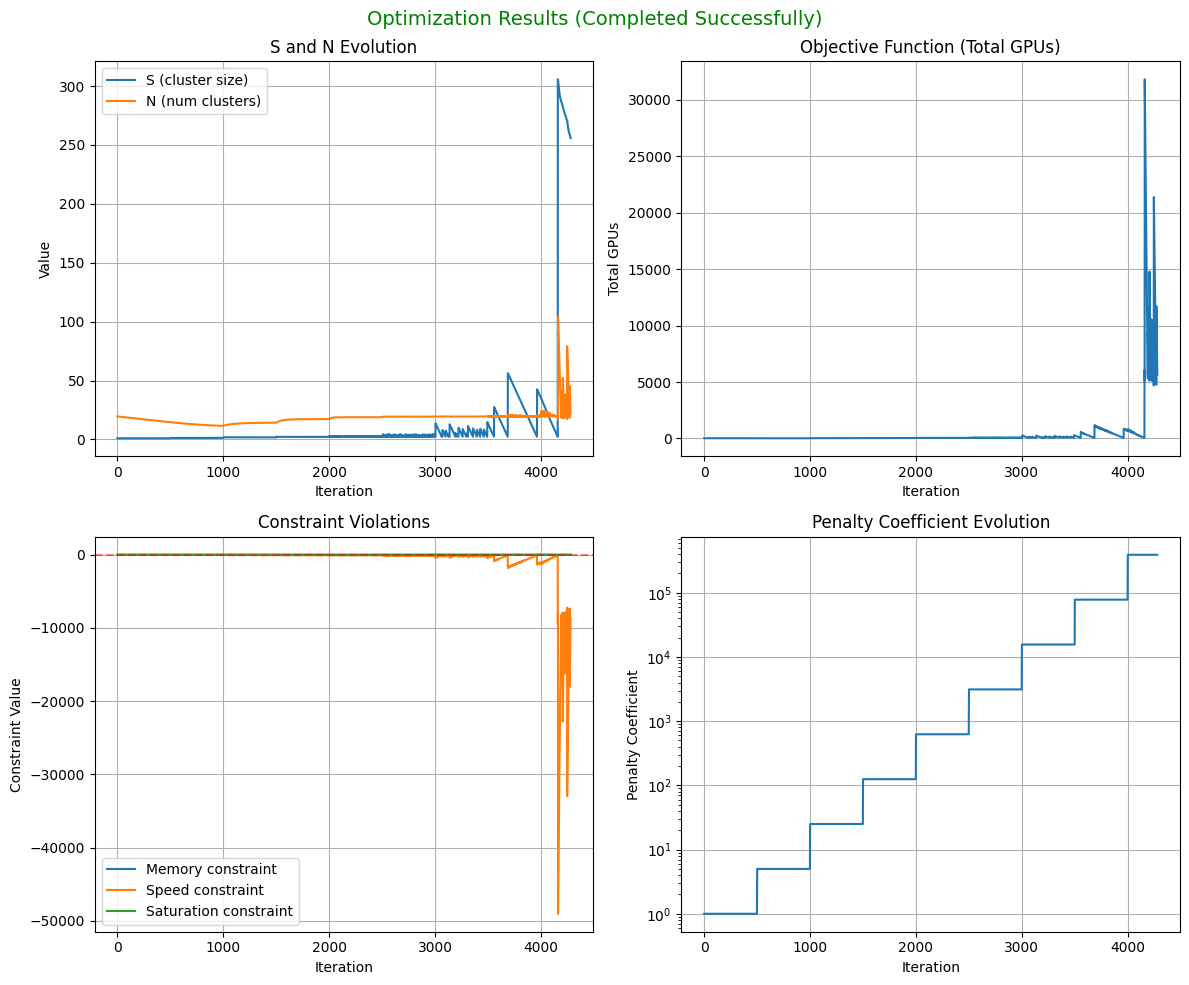


=== STABILITY ANALYSIS ===
✅ Optimization completed successfully
Total iterations: 4281
Stable iterations: 4281/4281
255.79787173795233 22.05707885647842 5642.153828243367


In [14]:
# Run the optimization test
S_optimal, N_optimal, optimization_results = test_optimization()
print(S_optimal, N_optimal, S_optimal * N_optimal)

On a une instabilité numérique forte à partir certain coefficient de pénalité, d'autres tests ont montré que même en l'absence de problèmes, l'algorithme n'arrive pas nécessairement à trouver une solution qui soit compatible avec les trois contraintes à la fois.

## Algorithme de grid search

En pratique, les paramètres que l'on cherche à optimiser existent sur $\mathbb{N}$. On peut donc tout à fait calculer de manière exhaustive la forme de notre fonction objectif et les contraintes associées sur un sous ensemble de $\mathbb{N}$ suffisamment grand pour qu'on soit quasi certains que la solution s'y trouve. On va établir ci-dessous quelques heuristiques pour déterminer les limite de cet ensemble de recherche.

### Bornes de l'ensemble de recherche

La contrainte de saturation donne immédiatement $\inf N = \frac{users}{batchsize}$.

Une borne supérieure de $S$ est donnée par le fait qu'il est à priori inutile d'avoir un nombre de clusters au sein d'un GPU qui soit supérieur à la batch size fixée par l'utilisateur, on a donc $\sup S = batchsize$. Une version ultérieure d'Infrascale pourrait considérer que la batch size n'est pas un paramètre fixé, ce qui impacterait cette heuristique, mais nous ferons cette hypothèse pour la V1.

Enfin, on peut déterminer une borne supérieure de $N$ en fixant $S=1$ et en calculant la valeur de $N$ qui permet de respecter la contrainte de vitesse.

On remarque que suite à ce travail, on s'est amenés à une situation où KKT est applicable, on ne l'utilisera pas immédiatement car c'est trop boringgggg!

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import validate_data, check_is_fitted
import numpy as np

class ConstraintsEstimator(BaseEstimator, TransformerMixin):

    def __init__(self, S=1, N=1, **kwargs):
        self.S = S
        self.N = N

        self.n_features_in_ = 2
        self.n_samples_in_ = 1
        self.n_features_out_ = 3
        self.n_samples_out_ = 1

        self.X_ = None

        for key, value in kwargs.items():
            setattr(self, key, value)

        self._param_names = list(kwargs.keys())

    def get_params(self, deep=True):
        return {param: getattr(self, param)
                for param in self._param_names}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self

    def fit(self, X, y=None):
        X = validate_data(self, X)

        self.X_ = X

        return self

    def transform(self, X):
        check_is_fitted(self)

        X = validate_data(self, X, reset=False)

        try:
            mem = 1 if calculate_mem_constraint(self.S, self.N, **self.get_params()) > 0 else 0
            saturation = 1 if calculate_saturation_constraint(self.S, self.N, **self.get_params()) > 0 else 0
            speed = 1 if calculate_speed_constraint(self.S, self.N, **self.get_params()) > 0 else 0
        except Exception as e:
            print(self.kwargs)

        return np.array([mem, saturation, speed])
    
    def score(self, X, y=None):
        return 1 - self.transform(X).mean()
        

In [16]:
def calculate_N_sup(**kwargs):
  target_speed = kwargs['target_speed']
  K = calculate_speed_constant(**kwargs)
  N = target_speed / K

  return N

In [17]:
from sklearn.model_selection import GridSearchCV
from math import ceil

params = {
    'users': 1000,
    'target_speed': 100,
    'batch_size': 256,
    'model_b_params': 24,  # Model size in billions of parameters
    'model_layers': 40,
    'model_dim': 5120,
    'bytes_per_param': 2,  # 2 bytes for half precision
    'tokens_per_request': 512,
    'memory_overhead_percent': 20,
    'prompt_size': 256,
    'efficiency_factor': 0.85,
    'gpu_vram_gb': 80,  # GPU VRAM in GB
    'gpu_flops': 1989,  # TFLOPS
    'gpu_bandwidth': 3350  # GB/s
}

sup_S = params['batch_size']
sup_N = ceil(max(calculate_N_sup(**params), params['users'] / params['batch_size']))

params_grid = {
  'S': np.arange(1, sup_S + 1),
  'N': np.arange(1, sup_N + 1),
}

# Create the estimator with the fixed parameters (excluding S and N which will be varied)
fixed_params = {k: v for k, v in params.items()}  # Make a copy
est = ConstraintsEstimator(S=1, N=1, **fixed_params)

# Use cv=2 since we need at least 2 folds for GridSearchCV to work properly
grid_search = GridSearchCV(est, params_grid, cv=2, verbose=1, scoring=None)

# Create dummy data for the fit (since we're not actually using X and y)
X_dummy = [[1, 2], [3, 4]]  # This doesn't matter for our constraint checking

print(f"\nStarting grid search with {len(params_grid['S']) * len(params_grid['N'])} parameter combinations...")
print(f"S range: {params_grid['S'].min()} to {params_grid['S'].max()}")
print(f"N range: {params_grid['N'].min()} to {params_grid['N'].max()}")

grid_search.fit(X_dummy)


Starting grid search with 1024 parameter combinations...
S range: 1 to 256
N range: 1 to 4
Fitting 2 folds for each of 1024 candidates, totalling 2048 fits


,estimator,"ConstraintsEs...2, users=1000)"
,param_grid,"{'N': array([1, 2, 3, 4]), 'S': array([ 1, ...54, 255, 256])}"
,scoring,None
,n_jobs,None
,refit,True
,cv,2
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,users,1000


In [18]:
# Test the implementation
print("Grid search completed successfully!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Test the best estimator
best_estimator = grid_search.best_estimator_
print(f"Best S: {best_estimator.S}, Best N: {best_estimator.N}")
print(f"Total GPUs: {best_estimator.S * best_estimator.N}")

# Verify constraints at the best solution
S_best, N_best = best_estimator.S, best_estimator.N
mem_constraint = calculate_mem_constraint(S_best, N_best, **params)
speed_constraint = calculate_speed_constraint(S_best, N_best, **params)
saturation_constraint = calculate_saturation_constraint(S_best, N_best, **params)

print(f"\nConstraint values at best solution:")
print(f"Memory constraint: {mem_constraint:.6f} (should be ≤ 0)")
print(f"Speed constraint: {speed_constraint:.6f} (should be ≤ 0)")
print(f"Saturation constraint: {saturation_constraint:.6f} (should be ≤ 0)")

all_satisfied = all(c <= 0 for c in [mem_constraint, speed_constraint, saturation_constraint])
print(f"\nAll constraints satisfied: {all_satisfied}")


Grid search completed successfully!
Best parameters: {'N': np.int64(4), 'S': np.int64(3)}
Best score: 1.0
Best S: 3, Best N: 4
Total GPUs: 12

Constraint values at best solution:
Memory constraint: -0.170833 (should be ≤ 0)
Speed constraint: -2.914235 (should be ≤ 0)
Saturation constraint: -0.023438 (should be ≤ 0)

All constraints satisfied: True


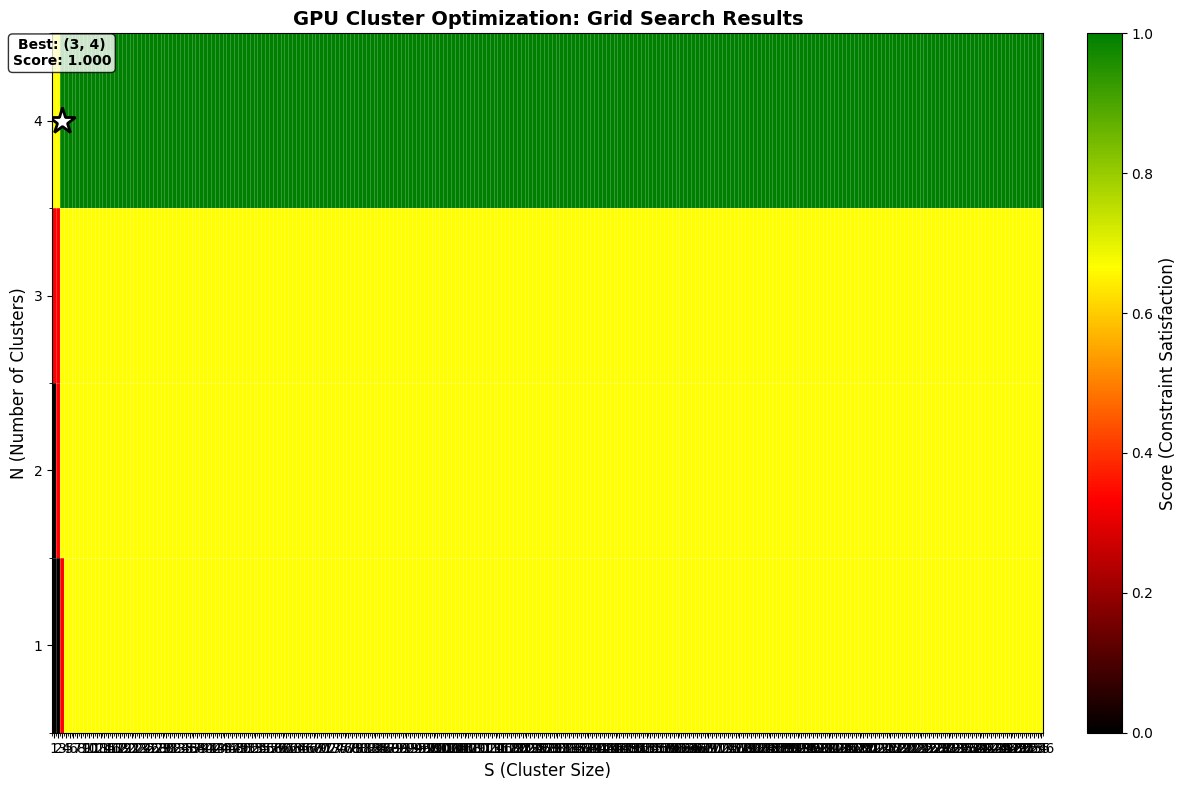

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

def visualize_grid_search_results(grid_search, param1_name='S', param2_name='N', 
                                figsize=(10, 8), title="Grid Search Results Heatmap"):
    """
    Visualize grid search results as a heatmap.
    
    Parameters:
    -----------
    grid_search : GridSearchCV
        The fitted grid search object
    param1_name : str
        Name of the first parameter (x-axis)
    param2_name : str  
        Name of the second parameter (y-axis)
    figsize : tuple
        Figure size (width, height)
    title : str
        Title for the plot
        
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    
    # Extract results from grid search
    results = grid_search.cv_results_
    
    # Get parameter values
    param1_values = np.unique([params[param1_name] for params in results['params']])
    param2_values = np.unique([params[param2_name] for params in results['params']])
    
    # Create score matrix
    score_matrix = np.zeros((len(param2_values), len(param1_values)))
    
    # Fill the matrix with scores
    for i, params in enumerate(results['params']):
        param1_idx = np.where(param1_values == params[param1_name])[0][0]
        param2_idx = np.where(param2_values == params[param2_name])[0][0]
        score_matrix[param2_idx, param1_idx] = results['mean_test_score'][i]
    
    # Create custom colormap: black (0) -> red -> green (1)
    colors = ['black', 'red', 'yellow', 'green']
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    im = ax.imshow(score_matrix, cmap=cmap, aspect='auto', origin='lower', 
                   vmin=0, vmax=1, interpolation='nearest')
    
    # Set ticks and labels
    ax.set_xticks(range(len(param1_values)))
    ax.set_yticks(range(len(param2_values)))
    ax.set_xticklabels(param1_values)
    ax.set_yticklabels(param2_values)
    
    # Add labels and title
    ax.set_xlabel(f'{param1_name} (Cluster Size)', fontsize=12)
    ax.set_ylabel(f'{param2_name} (Number of Clusters)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Score (Constraint Satisfaction)', fontsize=12)
    
    # Add grid for better readability
    ax.set_xticks(np.arange(-0.5, len(param1_values), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(param2_values), 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Highlight the best solution
    best_params = grid_search.best_params_
    best_param1_idx = np.where(param1_values == best_params[param1_name])[0][0]
    best_param2_idx = np.where(param2_values == best_params[param2_name])[0][0]
    
    # Add star marker for best solution
    ax.plot(best_param1_idx, best_param2_idx, marker='*', markersize=20, 
            color='white', markeredgecolor='black', markeredgewidth=2)
    
    # Add text annotation for best solution
    ax.text(best_param1_idx, best_param2_idx + 0.3, 
            f'Best: ({best_params[param1_name]}, {best_params[param2_name]})\nScore: {grid_search.best_score_:.3f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig, ax

# Create visualization for your grid search results
fig, ax = visualize_grid_search_results(
    grid_search, 
    param1_name='S', 
    param2_name='N',
    figsize=(12, 8),
    title="GPU Cluster Optimization: Grid Search Results"
)

plt.show()


Starting grid search with 2500 parameter combinations...
S range: 1 to 50
N range: 1 to 50
Fitting 2 folds for each of 2500 candidates, totalling 5000 fits


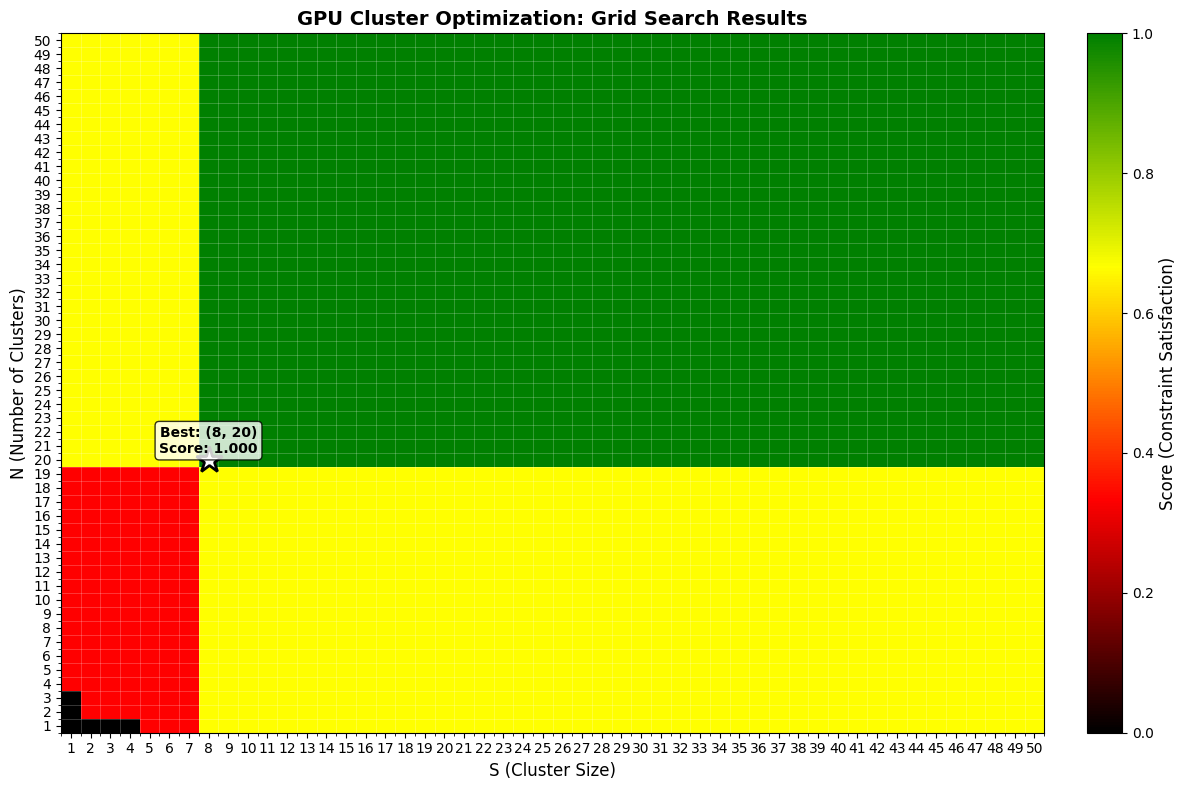

In [20]:
params = {
    'users': 5000,
    'target_speed': 100,
    'batch_size': 256,
    'model_b_params': 70,  # Model size in billions of parameters
    'model_layers': 80,
    'model_dim': 8192,
    'bytes_per_param': 2,  # 2 bytes for half precision
    'tokens_per_request': 512,
    'memory_overhead_percent': 20,
    'prompt_size': 256,
    'efficiency_factor': 0.85,
    'gpu_vram_gb': 80,  # GPU VRAM in GB
    'gpu_flops': 1989,  # TFLOPS
    'gpu_bandwidth': 3350  # GB/s
}

sup_S = 50
sup_N = 50

params_grid = {
  'S': np.arange(1, sup_S + 1),
  'N': np.arange(1, sup_N + 1),
}

# Create the estimator with the fixed parameters (excluding S and N which will be varied)
fixed_params = {k: v for k, v in params.items()}  # Make a copy
est = ConstraintsEstimator(S=1, N=1, **fixed_params)

# Use cv=2 since we need at least 2 folds for GridSearchCV to work properly
grid_search = GridSearchCV(est, params_grid, cv=2, verbose=1, scoring=None)

# Create dummy data for the fit (since we're not actually using X and y)
X_dummy = [[1, 2], [3, 4]]  # This doesn't matter for our constraint checking

print(f"\nStarting grid search with {len(params_grid['S']) * len(params_grid['N'])} parameter combinations...")
print(f"S range: {params_grid['S'].min()} to {params_grid['S'].max()}")
print(f"N range: {params_grid['N'].min()} to {params_grid['N'].max()}")

grid_search.fit(X_dummy)

fig, ax = visualize_grid_search_results(
    grid_search, 
    param1_name='S', 
    param2_name='N',
    figsize=(12, 8),
    title="GPU Cluster Optimization: Grid Search Results"
)

plt.show()


Starting grid search with 2500 parameter combinations...
S range: 1 to 50
N range: 1 to 50
Fitting 2 folds for each of 2500 candidates, totalling 5000 fits


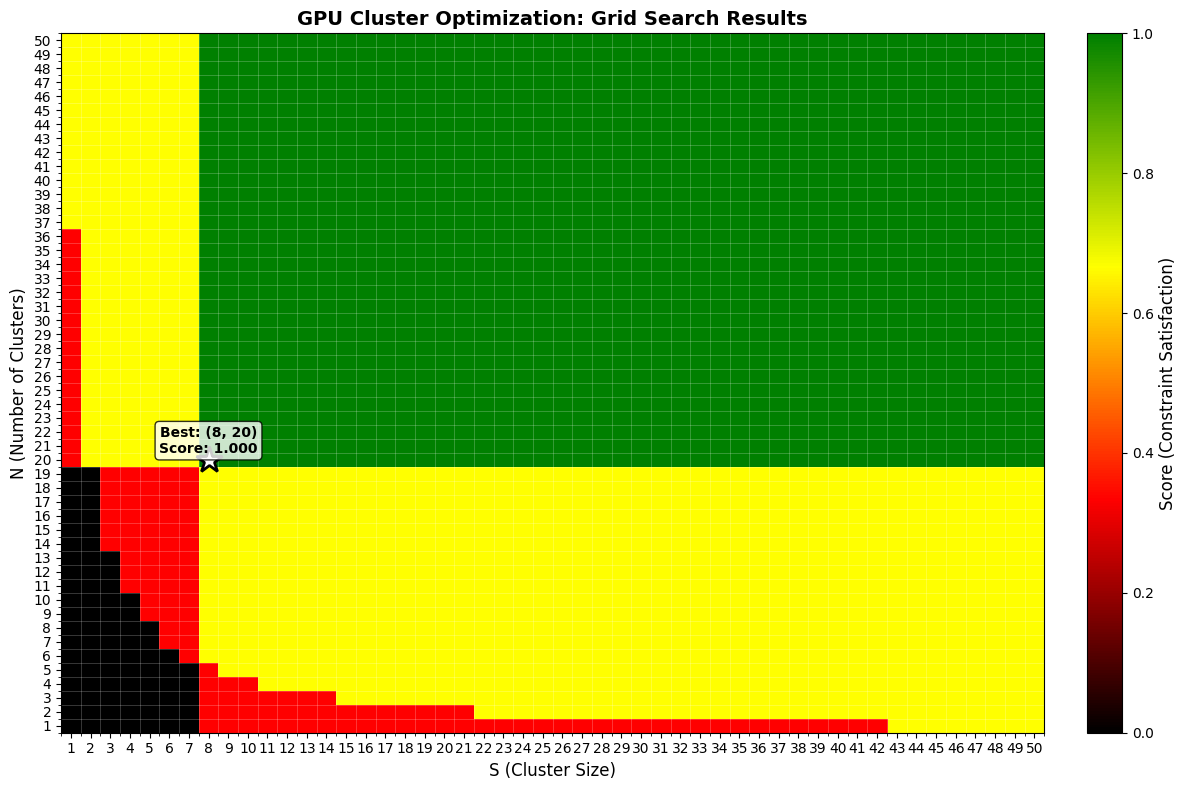

In [21]:
params = {
    'users': 5000,
    'target_speed': 1000,
    'batch_size': 256,
    'model_b_params': 70,  # Model size in billions of parameters
    'model_layers': 80,
    'model_dim': 8192,
    'bytes_per_param': 2,  # 2 bytes for half precision
    'tokens_per_request': 512,
    'memory_overhead_percent': 20,
    'prompt_size': 256,
    'efficiency_factor': 0.85,
    'gpu_vram_gb': 80,  # GPU VRAM in GB
    'gpu_flops': 1989,  # TFLOPS
    'gpu_bandwidth': 3350  # GB/s
}

sup_S = 50
sup_N = 50

params_grid = {
  'S': np.arange(1, sup_S + 1),
  'N': np.arange(1, sup_N + 1),
}

# Create the estimator with the fixed parameters (excluding S and N which will be varied)
fixed_params = {k: v for k, v in params.items()}  # Make a copy
est = ConstraintsEstimator(S=1, N=1, **fixed_params)

# Use cv=2 since we need at least 2 folds for GridSearchCV to work properly
grid_search = GridSearchCV(est, params_grid, cv=2, verbose=1, scoring=None)

# Create dummy data for the fit (since we're not actually using X and y)
X_dummy = [[1, 2], [3, 4]]  # This doesn't matter for our constraint checking

print(f"\nStarting grid search with {len(params_grid['S']) * len(params_grid['N'])} parameter combinations...")
print(f"S range: {params_grid['S'].min()} to {params_grid['S'].max()}")
print(f"N range: {params_grid['N'].min()} to {params_grid['N'].max()}")

grid_search.fit(X_dummy)

fig, ax = visualize_grid_search_results(
    grid_search, 
    param1_name='S', 
    param2_name='N',
    figsize=(12, 8),
    title="GPU Cluster Optimization: Grid Search Results"
)

plt.show()

## KKT

A priori les solutions du problème données par KKT sont $S^* = \max(1,\frac{K_{mem}-1}{E}+1)$ et $N^* = \max(1, \frac{users}{batchsize}, \frac{S^*}{K_{mem}K_{speed}})$.

Vérifions !

In [22]:
def calculate_N_sup(**kwargs):
  target_speed = kwargs['target_speed']
  K = calculate_speed_constant(**kwargs)
  N = target_speed / K

  return ceil(max(N , params['users'] / params['batch_size']))

In [23]:
params = {
    'users': 1000,
    'target_speed': 100,
    'batch_size': 256,
    'model_b_params': 24,  # Model size in billions of parameters
    'model_layers': 40,
    'model_dim': 5120,
    'bytes_per_param': 2,  # 2 bytes for half precision
    'tokens_per_request': 512,
    'memory_overhead_percent': 20,
    'prompt_size': 256,
    'efficiency_factor': 0.85,
    'gpu_vram_gb': 80,  # GPU VRAM in GB
    'gpu_flops': 1989,  # TFLOPS
    'gpu_bandwidth': 3350  # GB/s
}

In [24]:
K_mem = calculate_memory_constant(**params)
K_speed = calculate_speed_constant(**params)

N_sup = calculate_N_sup(**params)

S = max(1, (K_mem - 1) / params['efficiency_factor'] + 1)
N = max(1, params['users'] / params['batch_size'], S / (K_mem * K_speed))

if S > params['batch_size']:
  raise ValueError("S is greater than batch_size")

if N > N_sup:
  raise ValueError("N is greater than N_sup")

print(S, N)
print("ceiled:", ceil(S), ceil(N))

2.4573529411764707 3.90625
ceiled: 3 4


C'est super ! Mais il s'avère que le calcul de la contrainte de vitesse était faux depuis le départ, on devrait avoir $c_{speed}(S,N)= 1 - \frac{(1+E(S-1)) \times K_{speed}}{targetspeed \times \log_{10}(\frac{users}{N}+30)}$

Le terme logarithmique semble très arbitraire, mais il a été fixé dans le notebook associé à l'étape de calibration, il était caché $K_{speed}$ jusqu'ici mais il s'avère qu'il dépend de $N$. On a ainsi :

$S^* = \max(1,\frac{K_{mem}-1}{E}+1, target \times \frac{\log_{10}(\frac{users}{N}+30)}{K_{speed}\times E} - \frac{1}{E}+1)$ et $N^* = \max(1, \frac{users}{batchsize})$.

On va réimplémenter notre grid search avec la bonne contrainte de vitesse et on va vérifier que nous avons bien résolu le problème avec KKT correctement.

### Corrections

In [25]:
def calculate_speed_constant(**kwargs):
    users = kwargs['users']
    batch_size = kwargs['batch_size']
    prompt_size = kwargs['prompt_size']
    model_b_params = kwargs['model_b_params']
    model_dim = kwargs['model_dim']
    gpu_flops = kwargs['gpu_flops']
    gpu_bandwidth = kwargs['gpu_bandwidth']
    
    gpu_flops = gpu_flops * 10**12 * 0.55
    gpu_bandwidth = gpu_bandwidth * 10**12

    flops_decode_one_token = batch_size * model_b_params * 2 * 1e9
    mm_params = model_b_params*10**9
    mm_kv_read = 2 * batch_size * prompt_size * model_dim
    mm_kv_write = 2 * batch_size * model_dim
    mm_decode_one_token = 2 * (mm_params + mm_kv_read + mm_kv_write)
    tpot = max(flops_decode_one_token / gpu_flops, mm_decode_one_token / gpu_bandwidth)

    k = 24/model_b_params
    recalibration_factor = k**(-1/(k+1))
    calibrated_tpot = tpot / recalibration_factor

    throughput_one_gpu = 1 / calibrated_tpot

    return throughput_one_gpu

def calculate_speed_constraint(S, N, **kwargs):
  E = kwargs['efficiency_factor']
  target_speed = kwargs['target_speed']
  users = kwargs['users']
  batch_size = kwargs['batch_size']
  K = calculate_speed_constant(**kwargs)
  # constraint = 1 - (1 + E * (S - 1)) * K / (target_speed * log10(min(users/N, batch_size)+30))
  constraint = 1 - S ** (1 / (S + 1)) * K / (target_speed * log10(min(users/N, batch_size)+30))
  
  return constraint

def calculate_S_inf(N=1, **kwargs):
  target_speed = kwargs['target_speed']
  users = kwargs['users']
  batch_size = kwargs['batch_size']
  E = kwargs['efficiency_factor']
  K = calculate_speed_constant(**kwargs)
  S = target_speed * log10(min(users/N, batch_size)+30) / (K * E) - 1 / E + 1

  return ceil(S)

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import validate_data, check_is_fitted
import numpy as np

class ConstraintsEstimator(BaseEstimator, TransformerMixin):

    def __init__(self, S=1, N=1, **kwargs):
        self.S = S
        self.N = N

        self.n_features_in_ = 2
        self.n_samples_in_ = 1
        self.n_features_out_ = 3
        self.n_samples_out_ = 1

        self.X_ = None

        for key, value in kwargs.items():
            setattr(self, key, value)

        self._param_names = list(kwargs.keys())

    def get_params(self, deep=True):
        return {param: getattr(self, param)
                for param in self._param_names}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self

    def fit(self, X, y=None):
        X = validate_data(self, X)

        self.X_ = X

        return self

    def transform(self, X):
        check_is_fitted(self)

        X = validate_data(self, X, reset=False)

        try:
            mem = 1 if calculate_mem_constraint(self.S, self.N, **self.get_params()) > 0 else 0
            saturation = 1 if calculate_saturation_constraint(self.S, self.N, **self.get_params()) > 0 else 0
            speed = 1 if calculate_speed_constraint(self.S, self.N, **self.get_params()) > 0 else 0
        except Exception as e:
            print(self.kwargs)

        return np.array([mem, saturation, speed])
    
    def score(self, X, y=None):
        return 1 - self.transform(X).mean()
        

In [27]:
def solve_grid_search(**params):
  sup_S = params['batch_size']
  sup_N = ceil(params['users'] / params['batch_size'])

  sup_S = 50
  sup_N = 50

  params_grid = {
    'S': np.arange(1, sup_S + 1),
    'N': np.arange(1, sup_N + 1),
  }

  # Create the estimator with the fixed parameters (excluding S and N which will be varied)
  fixed_params = {k: v for k, v in params.items()}  # Make a copy
  est = ConstraintsEstimator(S=1, N=1, **fixed_params)

  # Use cv=2 since we need at least 2 folds for GridSearchCV to work properly
  grid_search = GridSearchCV(est, params_grid, cv=2, verbose=1, scoring=None)

  # Create dummy data for the fit (since we're not actually using X and y)
  X_dummy = [[1, 2], [3, 4]]  # This doesn't matter for our constraint checking

  grid_search.fit(X_dummy)

  return int(grid_search.best_params_['S']), int(grid_search.best_params_['N']), grid_search

Fitting 2 folds for each of 2500 candidates, totalling 5000 fits


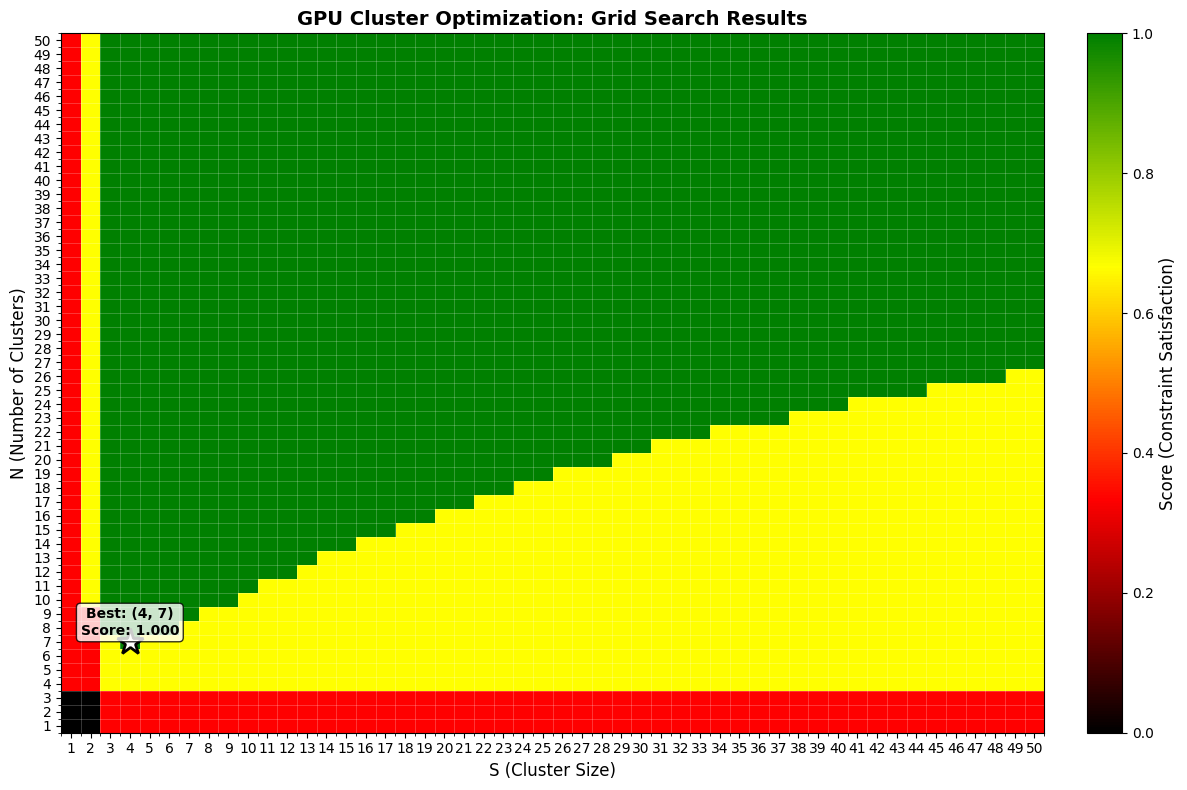

In [28]:
params = {
    'users': 1000,
    'target_speed': 40,
    'batch_size': 256,
    'model_b_params': 24,  # Model size in billions of parameters
    'model_layers': 40,
    'model_dim': 5120,
    'bytes_per_param': 2,  # 2 bytes for half precision
    'tokens_per_request': 512,
    'memory_overhead_percent': 20,
    'prompt_size': 256,
    'efficiency_factor': 0.85,
    'gpu_vram_gb': 80,  # GPU VRAM in GB
    'gpu_flops': 1979,  # TFLOPS
    'gpu_bandwidth': 3.35  # GB/s
}

grid_search = solve_grid_search(**params)[2]

fig, ax = visualize_grid_search_results(
    grid_search, 
    param1_name='S', 
    param2_name='N',
    figsize=(12, 8),
    title="GPU Cluster Optimization: Grid Search Results"
)

plt.show()

In [29]:
def solve_KKT(**params):
  K_mem = calculate_memory_constant(**params)

  N = max(1, params['users'] / params['batch_size'])

  S_inf = calculate_S_inf(N, **params)
  S = max(1, (K_mem - 1) / params['efficiency_factor'] + 1, S_inf)

  if S > params['batch_size']:
    raise ValueError("S is greater than batch_size")

  if N > params['users'] / params['batch_size']:
    raise ValueError("N is greater than users / batch_size")

  return ceil(S), ceil(N)

In [30]:
params = {
    'users': 1000,
    'target_speed': 100,
    'batch_size': 256,
    'model_b_params': 24,  # Model size in billions of parameters
    'model_layers': 40,
    'model_dim': 5120,
    'bytes_per_param': 2,  # 2 bytes for half precision
    'tokens_per_request': 512,
    'memory_overhead_percent': 20,
    'prompt_size': 256,
    'efficiency_factor': 0.85,
    'gpu_vram_gb': 80,  # GPU VRAM in GB
    'gpu_flops': 1979,  # TFLOPS
    'gpu_bandwidth': 3.35  # GB/s
}

print("Grid search:")
print(solve_grid_search(**params))

print("KKT:")
print(solve_KKT(**params))

Grid search:
Fitting 2 folds for each of 2500 candidates, totalling 5000 fits
(3, 4, GridSearchCV(cv=2,
             estimator=ConstraintsEstimator(batch_size=256, bytes_per_param=2,
                                            efficiency_factor=0.85,
                                            gpu_bandwidth=3.35, gpu_flops=1979,
                                            gpu_vram_gb=80,
                                            memory_overhead_percent=20,
                                            model_b_params=24, model_dim=5120,
                                            model_layers=40, prompt_size=256,
                                            target_speed=100,
                                            tokens_per_request=512,
                                            users=1000),
             param_grid={'N': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36

In [31]:
params = {
    'users': 2000,
    'target_speed': 500,
    'batch_size': 256,
    'model_b_params': 70,  # Model size in billions of parameters
    'model_layers': 80,
    'model_dim': 8192,
    'bytes_per_param': 2,  # 2 bytes for half precision
    'tokens_per_request': 512,
    'memory_overhead_percent': 20,
    'prompt_size': 256,
    'efficiency_factor': 0.85,
    'gpu_vram_gb': 80,  # GPU VRAM in GB
    'gpu_flops': 1989,  # TFLOPS
    'gpu_bandwidth': 3350  # GB/s
}

print("Grid search:")
print(solve_grid_search(**params))

print("KKT:")
print(solve_KKT(**params))

Grid search:
Fitting 2 folds for each of 2500 candidates, totalling 5000 fits
(8, 8, GridSearchCV(cv=2,
             estimator=ConstraintsEstimator(batch_size=256, bytes_per_param=2,
                                            efficiency_factor=0.85,
                                            gpu_bandwidth=3350, gpu_flops=1989,
                                            gpu_vram_gb=80,
                                            memory_overhead_percent=20,
                                            model_b_params=70, model_dim=8192,
                                            model_layers=80, prompt_size=256,
                                            target_speed=500,
                                            tokens_per_request=512,
                                            users=2000),
             param_grid={'N': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36

:)

## Batch size

Ajoutons un paramètre $B$ tel que $batchsize = 2^B$ et voyons ce qui se passe !

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import validate_data, check_is_fitted
import numpy as np

class ConstraintsEstimator3Params(BaseEstimator, TransformerMixin):

    def __init__(self, S=1, N=1, B=1, **kwargs):
        self.S = S
        self.N = N
        self.B = B

        self.n_features_in_ = 3
        self.n_samples_in_ = 1
        self.n_features_out_ = 3
        self.n_samples_out_ = 1

        self.X_ = None

        for key, value in kwargs.items():
            setattr(self, key, value)
        setattr(self, 'batch_size', 2**self.B)

        self._param_names = list(kwargs.keys())

    def get_params(self, deep=True):
        return {param: getattr(self, param)
                for param in self._param_names}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        setattr(self, 'batch_size', 2**self.B)

        return self

    def fit(self, X, y=None):
        X = validate_data(self, X)

        self.X_ = X

        return self

    def transform(self, X):
        check_is_fitted(self)

        X = validate_data(self, X, reset=False)

        try:
            mem = 1 if calculate_mem_constraint(self.S, self.N, **self.get_params()) > 0 else 0
            saturation = 1 if calculate_saturation_constraint(self.S, self.N, **self.get_params()) > 0 else 0
            speed = 1 if calculate_speed_constraint(self.S, self.N, **self.get_params()) > 0 else 0
        except Exception as e:
            print(self.kwargs)

        return np.array([mem, saturation, speed])
    
    def score(self, X, y=None):
        return 1/(self.S*self.N) if self.transform(X).mean() == 0 else 0
        

In [33]:
def solve_grid_search_3params(**params):
  sup_S = params['batch_size']
  sup_N = ceil(params['users'] / params['batch_size'])

  sup_S = 50
  sup_N = 50
  sup_B = 10

  params_grid = {
    'S': np.arange(1, sup_S + 1),
    'N': np.arange(1, sup_N + 1),
    'B': np.arange(1, sup_B + 1),
  }

  # Create the estimator with the fixed parameters (excluding S and N which will be varied)
  fixed_params = {k: v for k, v in params.items()}  # Make a copy
  est = ConstraintsEstimator3Params(S=1, N=1, B=1, **fixed_params)

  # Use cv=2 since we need at least 2 folds for GridSearchCV to work properly
  grid_search = GridSearchCV(est, params_grid, cv=2, verbose=1, scoring=None)

  # Create dummy data for the fit (since we're not actually using X and y)
  X_dummy = [[1, 2], [3, 4]]  # This doesn't matter for our constraint checking

  grid_search.fit(X_dummy)

  return int(grid_search.best_params_['S']), int(grid_search.best_params_['N']), 2**int(grid_search.best_params_['B'])

In [34]:
params = {
    'users': 5000,
    'target_speed': 20,
    'batch_size': 256,
    'model_b_params': 70,  # Model size in billions of parameters
    'model_layers': 80,
    'model_dim': 8192,
    'bytes_per_param': 2,  # 2 bytes for half precision
    'tokens_per_request': 512,
    'memory_overhead_percent': 20,
    'prompt_size': 256,
    'efficiency_factor': 0.85,
    'gpu_vram_gb': 80,  # GPU VRAM in GB
    'gpu_flops': 1979,  # TFLOPS
    'gpu_bandwidth': 3.35  # GB/s
}

print(solve_grid_search_3params(**params))
print(solve_grid_search(**params))

Fitting 2 folds for each of 25000 candidates, totalling 50000 fits
(8, 20, 256)
Fitting 2 folds for each of 2500 candidates, totalling 5000 fits
(8, 20, GridSearchCV(cv=2,
             estimator=ConstraintsEstimator(batch_size=256, bytes_per_param=2,
                                            efficiency_factor=0.85,
                                            gpu_bandwidth=3.35, gpu_flops=1979,
                                            gpu_vram_gb=80,
                                            memory_overhead_percent=20,
                                            model_b_params=70, model_dim=8192,
                                            model_layers=80, prompt_size=256,
                                            target_speed=20,
                                            tokens_per_request=512,
                                            users=5000),
             param_grid={'N': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21

## Intercommuncations

Actuellement nous faisons l'hypothèse implicite que les GPUs d'un cluster sont reliés en SXM pour calculer les contraintes de vitesse. Essayons de généraliser en prenant en compte d'autres types de connexions. Sachant que  $K_{speed} = \frac{\lambda}{tpot}$, on a à présent :

$tpot' = tpot + t_{intercomm}$

$t_{intercomm} = \frac{N-1}{N} \times \frac{batchsize \times dim_{hidden} \times layers \times bytes_{/param}}{bandwidth_{intercomm}}$

Il vient que :

$c_{speed}(S,N)= 1 - \frac{(1+E(S-1))}{targetspeed \times \log_{10}(\frac{users}{N}+30)} \times \frac{\lambda}{\mu + \frac{N-1}{N}\gamma}$

où $\lambda$ est le facteur de calibration par rapport à la taille du modèle, $\mu = tpot$ et $\gamma = \frac{batchsize \times dim_{hidden} \times layers \times bytes_{/param}}{bandwidth_{intercomm}}$

In [121]:
from math import log10, ceil

def calculate_speed_constants(**kwargs):
    users = kwargs['users']
    bytes_per_param = kwargs['bytes_per_param']
    batch_size = kwargs['batch_size']
    prompt_size = kwargs['prompt_size']
    model_b_params = kwargs['model_b_params']
    model_dim = kwargs['model_dim']
    model_layers = kwargs['model_layers']
    gpu_flops = kwargs['gpu_flops']
    gpu_bandwidth = kwargs['gpu_bandwidth']
    intercomm_bandwidth = kwargs['intercomm_bandwidth']
    
    gpu_flops = gpu_flops * 10**12 * 0.55
    gpu_bandwidth = gpu_bandwidth * 10**12

    flops_decode_one_token = batch_size * model_b_params * 2 * 1e9
    mm_params = model_b_params*10**9
    mm_kv_read = 2 * batch_size * prompt_size * model_dim
    mm_kv_write = 2 * batch_size * model_dim
    mm_decode_one_token = 2 * (mm_params + mm_kv_read + mm_kv_write)
    mu = max(flops_decode_one_token / gpu_flops, mm_decode_one_token / gpu_bandwidth)

    k = 24/model_b_params
    l = k**(-1/(k+1))
    
    gamma = batch_size * model_dim * model_layers * bytes_per_param / (intercomm_bandwidth * 10**9)

    return l, mu, gamma

def calculate_speed_constraint(S, N, **kwargs):
  E = kwargs['efficiency_factor']
  target_speed = kwargs['target_speed']
  users = kwargs['users']
  batch_size = kwargs['batch_size']
  l, mu, gamma = calculate_speed_constants(**kwargs)
  constraint = 1 - ((1 + E * (S - 1)) * l) / (target_speed * log10(min(users/N, batch_size)+30) * (mu + gamma * (S-1)/S))
  
  return constraint

def calculate_S_inf(N=1, **kwargs):
  target_speed = kwargs['target_speed']
  users = kwargs['users']
  batch_size = kwargs['batch_size']
  E = kwargs['efficiency_factor']
  K = calculate_speed_constant(**kwargs)
  S = target_speed * log10(min(users/N, batch_size)+30) / (K * E) - 1 / E + 1

  return ceil(S)

In [122]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import validate_data, check_is_fitted
import numpy as np

class ConstraintsEstimator3Params(BaseEstimator, TransformerMixin):

    def __init__(self, S=1, N=1, B=1, **kwargs):
        self.S = S
        self.N = N
        self.B = B

        self.n_features_in_ = 3
        self.n_samples_in_ = 1
        self.n_features_out_ = 3
        self.n_samples_out_ = 1

        self.X_ = None

        for key, value in kwargs.items():
            setattr(self, key, value)
        setattr(self, 'batch_size', 2**self.B)

        self._param_names = list(kwargs.keys())

    def get_params(self, deep=True):
        return {param: getattr(self, param)
                for param in self._param_names}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        setattr(self, 'batch_size', 2**self.B)

        return self

    def fit(self, X, y=None):
        X = validate_data(self, X)

        self.X_ = X

        return self

    def transform(self, X):
        check_is_fitted(self)

        X = validate_data(self, X, reset=False)

        try:
            mem = 1 if calculate_mem_constraint(self.S, self.N, **self.get_params()) > 0 else 0
            saturation = 1 if calculate_saturation_constraint(self.S, self.N, **self.get_params()) > 0 else 0
            speed = 1 if calculate_speed_constraint(self.S, self.N, **self.get_params()) > 0 else 0
        except Exception as e:
            print(self.kwargs)

        return np.array([mem, saturation, speed])
    
    def score(self, X, y=None):
        return 1/(self.S*self.N) if self.transform(X).mean() == 0 else 0
        

In [140]:
def solve_grid_search_3params(**params):
  sup_S = params['batch_size']
  sup_N = ceil(params['users'] / params['batch_size'])

  sup_S = 50
  sup_N = 50
  sup_B = 9

  params_grid = {
    'S': np.arange(1, sup_S + 1),
    'N': np.arange(1, sup_N + 1),
    'B': np.arange(1, sup_B + 1),
  }

  # Create the estimator with the fixed parameters (excluding S and N which will be varied)
  fixed_params = {k: v for k, v in params.items()}  # Make a copy
  est = ConstraintsEstimator3Params(S=1, N=1, B=1, **fixed_params)

  # Use cv=2 since we need at least 2 folds for GridSearchCV to work properly
  grid_search = GridSearchCV(est, params_grid, cv=2, verbose=1, scoring=None)

  # Create dummy data for the fit (since we're not actually using X and y)
  X_dummy = [[1, 2], [3, 4]]  # This doesn't matter for our constraint checking

  grid_search.fit(X_dummy)

  return int(grid_search.best_params_['S']), int(grid_search.best_params_['N']), 2**int(grid_search.best_params_['B'])

In [151]:
params = {
    'users': 5000,
    'target_speed': 10,
    'batch_size': 256,
    'model_b_params': 70,  # Model size in billions of parameters
    'model_layers': 80,
    'model_dim': 8192,
    'bytes_per_param': 2,  # 2 bytes for half precision
    'tokens_per_request': 512,
    'memory_overhead_percent': 20,
    'prompt_size': 256,
    'efficiency_factor': 0.85,
    'gpu_vram_gb': 80,  # GPU VRAM in GB
    'gpu_flops': 1979,  # TFLOPS
    'gpu_bandwidth': 3.35,  # TB/s
    'intercomm_bandwidth': 32  # GB/s
}

print(solve_grid_search_3params(**params))

Fitting 2 folds for each of 22500 candidates, totalling 45000 fits
(14, 10, 512)
